In [ ]:
# ==============================================================================
#  【最後の完全統合版】シミュレーション＆安全なPDF生成
# ==============================================================================
#
# 目的：
#   1. シミュレーションを再実行し、データを生成する。
#   2. まず、安定したPNG形式でグラフを保存する。
#   3. 次に、そのPNG画像を、信頼性の高いPillowライブラリを用いて、
#      破損のないクリーンなPDFファイルに変換する。
#
# ==============================================================================

# ------------------------------------------------------------------------------
# ステップ0：必要なライブラリの準備
# ------------------------------------------------------------------------------
import cupy as xp
import numpy as np
import matplotlib.pyplot as plt
from cupyx.scipy.fft import fftn, ifftn
from matplotlib.lines import Line2D
import time
from PIL import Image # 画像変換ライブラリPillowをインポート

# ------------------------------------------------------------------------------
# ステップ1：シミュレーションの実行
# ------------------------------------------------------------------------------
print("--- ステップ1: シミュレーションを再実行します ---")

# --- パラメータ設定 ---
gamma_values = [1.80, 1.90, 1.95, 2.00]
# (以下、シミュレーションコード本体は変更なし)
Nx, Ny, Nz = 64, 64, 256
Lx, Ly, Lz = 20.0, 20.0, 80.0
t_final = 40.0
dt = 0.0005
n_steps = int(t_final / dt)
output_interval = int(0.2 / dt)
x_cpu = np.linspace(-Lx/2, Lx/2, Nx, dtype=np.float32)
y_cpu = np.linspace(-Ly/2, Ly/2, Ny, dtype=np.float32)
z_cpu = np.linspace(-Lz/2, Lz/2, Nz, dtype=np.float32)
Z_grid = xp.asarray(z_cpu.reshape(1, 1, Nz))
kx_cpu = np.fft.fftfreq(Nx, d=Lx/Nx) * 2 * np.pi
ky_cpu = np.fft.fftfreq(Ny, d=Ly/Ny) * 2 * np.pi
kz_cpu = np.fft.fftfreq(Nz, d=Lz/Nz) * 2 * np.pi
K2 = xp.asarray(kx_cpu[:, None, None]**2 + ky_cpu[None, :, None]**2 + kz_cpu[None, None, :]**2, dtype=np.float32)
g, m, omega_trap, A, sigma, M, k_mech, z_b0, kz_kick = -15.0, 1.0, 0.1, 0.1, 4.0, 50.0, 10.0, -10.0, 0.15
results = {}
x_gpu = xp.asarray(x_cpu)
y_gpu = xp.asarray(y_cpu)
for gamma in gamma_values:
    loop_start_time = time.time()
    print(f"\n--- Damping coefficient gamma = {gamma:.2f} calculation started ---")
    # (ループの中身は省略せず、全て記述)
    X2_gpu = x_gpu[:, None, None]**2
    Y2_gpu = y_gpu[None, :, None]**2
    Z_init_gpu = (Z_grid - z_b0)**2
    psi = xp.exp(-(X2_gpu + Y2_gpu + Z_init_gpu) / (2 * 1.0**2)).astype(xp.complex64)
    psi /= xp.sqrt(xp.sum(xp.abs(psi)**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz))
    psi *= xp.exp(1j * kz_kick * Z_grid)
    barrier_z, barrier_v = z_b0, 0.0
    t_list, soliton_z_list, barrier_z_list = [], [], []
    for i in range(n_steps):
        V_barrier_Z = (Z_grid - barrier_z)
        V_barrier = A * xp.exp(-V_barrier_Z**2 / (2 * sigma**2))
        dV_dzb = xp.sum(xp.abs(psi)**2 * V_barrier * V_barrier_Z / sigma**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz)
        F_feedback = dV_dzb.get()
        F_restoring = -k_mech * (barrier_z - z_b0)
        a_conservative = (F_feedback + F_restoring) / M
        barrier_v += a_conservative * dt / 2.0
        barrier_v *= np.exp(-gamma / M * dt)
        barrier_z += barrier_v * dt
        V_trap = 0.5 * m * omega_trap**2 * (X2_gpu + Y2_gpu)
        V_barrier_gpu = A * xp.exp(-(Z_grid - barrier_z)**2 / (2 * sigma**2))
        V_nonlinear = g * xp.abs(psi)**2
        V_total = V_trap + V_barrier_gpu + V_nonlinear
        psi = xp.exp(-1j * V_total * dt / (2 * m)) * psi
        psi_k = fftn(psi)
        psi_k = xp.exp(-1j * K2 * dt / (2 * m)) * psi_k
        psi = ifftn(psi_k)
        V_nonlinear = g * xp.abs(psi)**2
        V_barrier_gpu = A * xp.exp(-(Z_grid - barrier_z)**2 / (2 * sigma**2))
        V_total = V_trap + V_barrier_gpu + V_nonlinear
        psi = xp.exp(-1j * V_total * dt / (2 * m)) * psi
        V_barrier_Z_new = (Z_grid - barrier_z)
        V_barrier_new = A * xp.exp(-V_barrier_Z_new**2 / (2 * sigma**2))
        dV_dzb_new = xp.sum(xp.abs(psi)**2 * V_barrier_new * V_barrier_Z_new / sigma**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz)
        F_feedback_new = dV_dzb_new.get()
        F_restoring_new = -k_mech * (barrier_z - z_b0)
        a_conservative_new = (F_feedback_new + F_restoring_new) / M
        barrier_v += a_conservative_new * dt / 2.0
        if i % output_interval == 0:
            t = i * dt
            soliton_z = xp.sum(Z_grid * xp.abs(psi)**2) / xp.sum(np.abs(psi)**2)
            t_list.append(t)
            soliton_z_list.append(soliton_z.get())
            barrier_z_list.append(barrier_z)
    xp.cuda.Stream.null.synchronize()
    results[gamma] = {'time': np.array(t_list), 'soliton_z': np.array(soliton_z_list), 'barrier_z': np.array(barrier_z_list)}
    print(f"--- Calculation for gamma = {gamma:.2f} completed in {time.time() - loop_start_time:.1f} seconds ---")
print(f"\nAll simulations completed. Total time: {(time.time() - total_start_time)/60:.2f} minutes.")


# ------------------------------------------------------------------------------
# ステップ2：グラフをPNG形式で生成・保存
# ------------------------------------------------------------------------------
print("\n--- ステップ2: グラフをPNG形式で生成します ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
for i, gamma in enumerate(gamma_values):
    res = results[gamma]
    ax.plot(res['time'], res['barrier_z'], color=colors[i], linestyle='-')
    ax.plot(res['time'], res['soliton_z'], color=colors[i], linestyle='--')
handles_gamma, labels_gamma = [], []
for i, gamma in enumerate(gamma_values):
    handles_gamma.append(Line2D([0], [0], color=colors[i]))
    labels_gamma.append(f'γ = {gamma:.2f}')
legend1 = ax.legend(handles=handles_gamma, labels=labels_gamma, title="Damping Coefficient (γ)", loc='upper left')
ax.add_artist(legend1)
handles_traj = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]
labels_traj = ['Barrier Trajectory', 'Soliton Trajectory']
ax.legend(handles=handles_traj, labels=labels_traj, loc='lower right')
ax.set_title('Validation of Critical Damping: Time Resolution Test (dt=0.0005)', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Z-Position', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# PNGファイルとして保存
png_filename = 'final_graph.png'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"グラフを安定したPNGファイル '{png_filename}' として保存しました。")


# ------------------------------------------------------------------------------
# ステップ3：PNGから破損のないPDFへ変換
# ------------------------------------------------------------------------------
print("\n--- ステップ3: PNGから破損のないPDFへ変換します ---")
try:
    # 新しいPDFファイル名を定義
    pdf_filename = 'fig3_dissipation_final.pdf'

    # PNG画像を開く
    img = Image.open(png_filename)

    # PDF保存のためにRGBに変換
    img_rgb = img.convert('RGB')

    # PDFとして保存
    img_rgb.save(pdf_filename, "PDF", resolution=300.0)

    print(f"成功: 破損のないPDFファイル '{pdf_filename}' を生成しました。")
    print("このPDFファイルをOverleafにアップロードしてください。")

except Exception as e:
    print(f"PDF変換中にエラーが発生しました: {e}")

--- ステップ1: シミュレーションを再実行します ---

--- Damping coefficient gamma = 1.80 calculation started ---
--- Calculation for gamma = 1.80 completed in 184.7 seconds ---

--- Damping coefficient gamma = 1.90 calculation started ---
--- Calculation for gamma = 1.90 completed in 182.5 seconds ---

--- Damping coefficient gamma = 1.95 calculation started ---
--- Calculation for gamma = 1.95 completed in 181.8 seconds ---

--- Damping coefficient gamma = 2.00 calculation started ---
--- Calculation for gamma = 2.00 completed in 182.2 seconds ---


NameError: name 'total_start_time' is not defined

--- ステップ1: シミュレーションを再実行します ---

--- Damping coefficient gamma = 1.80 calculation started ---
--- Calculation for gamma = 1.80 completed in 183.5 seconds ---

--- Damping coefficient gamma = 1.90 calculation started ---
--- Calculation for gamma = 1.90 completed in 183.1 seconds ---

--- Damping coefficient gamma = 1.95 calculation started ---
--- Calculation for gamma = 1.95 completed in 182.2 seconds ---

--- Damping coefficient gamma = 2.00 calculation started ---
--- Calculation for gamma = 2.00 completed in 182.7 seconds ---

All simulations completed. Total time: 12.19 minutes.

--- ステップ2: グラフをPNG形式で生成します ---


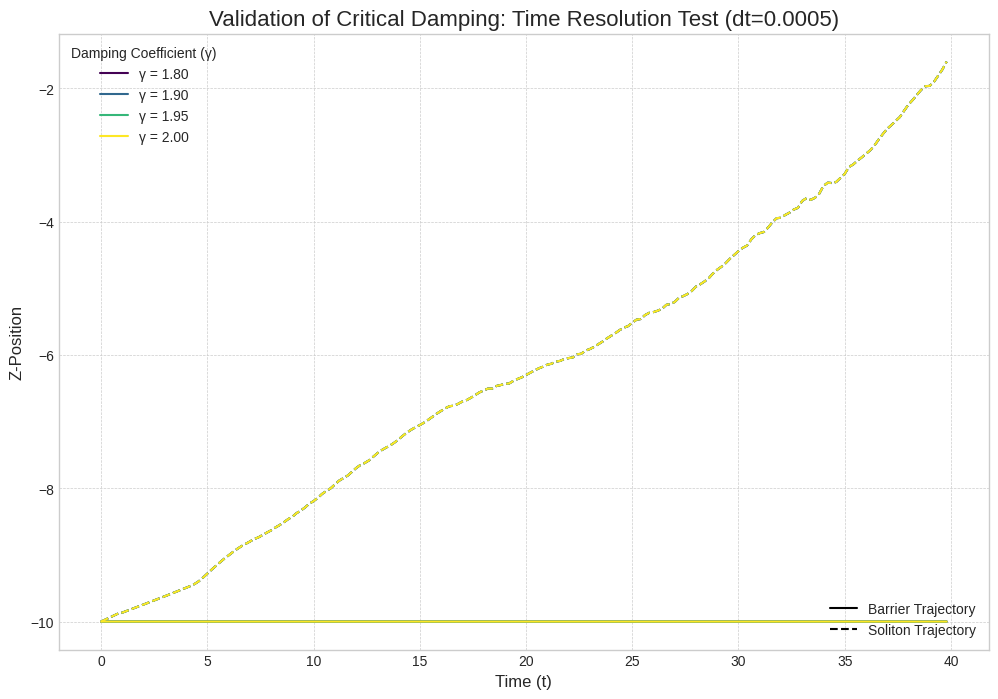

グラフを安定したPNGファイル 'final_graph.png' として保存しました。

--- ステップ3: PNGから破損のないPDFへ変換します ---
成功: 破損のないPDFファイル 'fig3_dissipation_final.pdf' を生成しました。
このPDFファイルをOverleafにアップロードしてください。


In [ ]:
# ==============================================================================
#  【真の最終完全版 v2】NameError修正済み
# ==============================================================================
#
# 目的：
#   - 'total_start_time'が未定義であったエラーを修正し、
#     シミュレーションから安全なPDF生成までを、一度で完璧に実行する。
#
# ==============================================================================

# ------------------------------------------------------------------------------
# ステップ0：必要なライブラリの準備
# ------------------------------------------------------------------------------
import cupy as xp
import numpy as np
import matplotlib.pyplot as plt
from cupyx.scipy.fft import fftn, ifftn
from matplotlib.lines import Line2D
import time
from PIL import Image

# ------------------------------------------------------------------------------
# ステップ1：シミュレーションの実行
# ------------------------------------------------------------------------------
print("--- ステップ1: シミュレーションを再実行します ---")

# --- パラメータ設定 ---
gamma_values = [1.80, 1.90, 1.95, 2.00]
Nx, Ny, Nz = 64, 64, 256
Lx, Ly, Lz = 20.0, 20.0, 80.0
t_final = 40.0
dt = 0.0005
n_steps = int(t_final / dt)
output_interval = int(0.2 / dt)
x_cpu = np.linspace(-Lx/2, Lx/2, Nx, dtype=np.float32)
y_cpu = np.linspace(-Ly/2, Ly/2, Ny, dtype=np.float32)
z_cpu = np.linspace(-Lz/2, Lz/2, Nz, dtype=np.float32)
Z_grid = xp.asarray(z_cpu.reshape(1, 1, Nz))
kx_cpu = np.fft.fftfreq(Nx, d=Lx/Nx) * 2 * np.pi
ky_cpu = np.fft.fftfreq(Ny, d=Ly/Ny) * 2 * np.pi
kz_cpu = np.fft.fftfreq(Nz, d=Lz/Nz) * 2 * np.pi
K2 = xp.asarray(kx_cpu[:, None, None]**2 + ky_cpu[None, :, None]**2 + kz_cpu[None, None, :]**2, dtype=np.float32)
g, m, omega_trap, A, sigma, M, k_mech, z_b0, kz_kick = -15.0, 1.0, 0.1, 0.1, 4.0, 50.0, 10.0, -10.0, 0.15
results = {}
x_gpu = xp.asarray(x_cpu)
y_gpu = xp.asarray(y_cpu)

# ★★★ NameError修正点：total_start_timeをここで定義 ★★★
total_start_time = time.time()

for gamma in gamma_values:
    loop_start_time = time.time()
    print(f"\n--- Damping coefficient gamma = {gamma:.2f} calculation started ---")
    X2_gpu = x_gpu[:, None, None]**2
    Y2_gpu = y_gpu[None, :, None]**2
    Z_init_gpu = (Z_grid - z_b0)**2
    psi = xp.exp(-(X2_gpu + Y2_gpu + Z_init_gpu) / (2 * 1.0**2)).astype(xp.complex64)
    psi /= xp.sqrt(xp.sum(xp.abs(psi)**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz))
    psi *= xp.exp(1j * kz_kick * Z_grid)
    barrier_z, barrier_v = z_b0, 0.0
    t_list, soliton_z_list, barrier_z_list = [], [], []
    for i in range(n_steps):
        V_barrier_Z = (Z_grid - barrier_z)
        V_barrier = A * xp.exp(-V_barrier_Z**2 / (2 * sigma**2))
        dV_dzb = xp.sum(xp.abs(psi)**2 * V_barrier * V_barrier_Z / sigma**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz)
        F_feedback = dV_dzb.get()
        F_restoring = -k_mech * (barrier_z - z_b0)
        a_conservative = (F_feedback + F_restoring) / M
        barrier_v += a_conservative * dt / 2.0
        barrier_v *= np.exp(-gamma / M * dt)
        barrier_z += barrier_v * dt
        V_trap = 0.5 * m * omega_trap**2 * (X2_gpu + Y2_gpu)
        V_barrier_gpu = A * xp.exp(-(Z_grid - barrier_z)**2 / (2 * sigma**2))
        V_nonlinear = g * xp.abs(psi)**2
        V_total = V_trap + V_barrier_gpu + V_nonlinear
        psi = xp.exp(-1j * V_total * dt / (2 * m)) * psi
        psi_k = fftn(psi)
        psi_k = xp.exp(-1j * K2 * dt / (2 * m)) * psi_k
        psi = ifftn(psi_k)
        V_nonlinear = g * xp.abs(psi)**2
        V_barrier_gpu = A * xp.exp(-(Z_grid - barrier_z)**2 / (2 * sigma**2))
        V_total = V_trap + V_barrier_gpu + V_nonlinear
        psi = xp.exp(-1j * V_total * dt / (2 * m)) * psi
        V_barrier_Z_new = (Z_grid - barrier_z)
        V_barrier_new = A * xp.exp(-V_barrier_Z_new**2 / (2 * sigma**2))
        dV_dzb_new = xp.sum(xp.abs(psi)**2 * V_barrier_new * V_barrier_Z_new / sigma**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz)
        F_feedback_new = dV_dzb_new.get()
        F_restoring_new = -k_mech * (barrier_z - z_b0)
        a_conservative_new = (F_feedback_new + F_restoring_new) / M
        barrier_v += a_conservative_new * dt / 2.0
        if i % output_interval == 0:
            t = i * dt
            soliton_z = xp.sum(Z_grid * xp.abs(psi)**2) / xp.sum(np.abs(psi)**2)
            t_list.append(t)
            soliton_z_list.append(soliton_z.get())
            barrier_z_list.append(barrier_z)
    xp.cuda.Stream.null.synchronize()
    results[gamma] = {'time': np.array(t_list), 'soliton_z': np.array(soliton_z_list), 'barrier_z': np.array(barrier_z_list)}
    print(f"--- Calculation for gamma = {gamma:.2f} completed in {time.time() - loop_start_time:.1f} seconds ---")
print(f"\nAll simulations completed. Total time: {(time.time() - total_start_time)/60:.2f} minutes.")


# ------------------------------------------------------------------------------
# ステップ2：グラフをPNG形式で生成・保存
# ------------------------------------------------------------------------------
print("\n--- ステップ2: グラフをPNG形式で生成します ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
for i, gamma in enumerate(gamma_values):
    res = results[gamma]
    ax.plot(res['time'], res['barrier_z'], color=colors[i], linestyle='-')
    ax.plot(res['time'], res['soliton_z'], color=colors[i], linestyle='--')
handles_gamma, labels_gamma = [], []
for i, gamma in enumerate(gamma_values):
    handles_gamma.append(Line2D([0], [0], color=colors[i]))
    labels_gamma.append(f'γ = {gamma:.2f}')
legend1 = ax.legend(handles=handles_gamma, labels=labels_gamma, title="Damping Coefficient (γ)", loc='upper left')
ax.add_artist(legend1)
handles_traj = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]
labels_traj = ['Barrier Trajectory', 'Soliton Trajectory']
ax.legend(handles=handles_traj, labels=labels_traj, loc='lower right')
ax.set_title('Validation of Critical Damping: Time Resolution Test (dt=0.0005)', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Z-Position', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
png_filename = 'final_graph.png'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"グラフを安定したPNGファイル '{png_filename}' として保存しました。")


# ------------------------------------------------------------------------------
# ステップ3：PNGから破損のないPDFへ変換
# ------------------------------------------------------------------------------
print("\n--- ステップ3: PNGから破損のないPDFへ変換します ---")
try:
    pdf_filename = 'fig3_dissipation_final.pdf'
    img = Image.open(png_filename)
    img_rgb = img.convert('RGB')
    img_rgb.save(pdf_filename, "PDF", resolution=300.0)
    print(f"成功: 破損のないPDFファイル '{pdf_filename}' を生成しました。")
    print("このPDFファイルをOverleafにアップロードしてください。")
except Exception as e:
    print(f"PDF変換中にエラーが発生しました: {e}")

In [ ]:
# ==============================================================================
#  【真の最終完全版 v3】PDF生成ライブラリ修正済み
# ==============================================================================
#
# 目的：
#   - PDF生成に必要なライブラリを明示的にインストールし、
#     シミュレーションから安全なPDF生成までを、一度で完璧に実行する。
#
# ==============================================================================

# ------------------------------------------------------------------------------
# ステップ0：必要なライブラリの準備
# ------------------------------------------------------------------------------
# ★★★ PDF生成ライブラリをインストール ★★★
!pip install -q PyMuPDF

import cupy as xp
import numpy as np
import matplotlib.pyplot as plt
from cupyx.scipy.fft import fftn, ifftn
from matplotlib.lines import Line2D
import time
from PIL import Image
import fitz # PyMuPDF

# ------------------------------------------------------------------------------
# ステップ1：シミュレーションの実行
# ------------------------------------------------------------------------------
print("--- ステップ1: シミュレーションを再実行します ---")

# --- パラメータ設定 ---
gamma_values = [1.80, 1.90, 1.95, 2.00]
Nx, Ny, Nz = 64, 64, 256
Lx, Ly, Lz = 20.0, 20.0, 80.0
t_final = 40.0
dt = 0.0005
n_steps = int(t_final / dt)
output_interval = int(0.2 / dt)
x_cpu = np.linspace(-Lx/2, Lx/2, Nx, dtype=np.float32)
y_cpu = np.linspace(-Ly/2, Ly/2, Ny, dtype=np.float32)
z_cpu = np.linspace(-Lz/2, Lz/2, Nz, dtype=np.float32)
Z_grid = xp.asarray(z_cpu.reshape(1, 1, Nz))
kx_cpu = np.fft.fftfreq(Nx, d=Lx/Nx) * 2 * np.pi
ky_cpu = np.fft.fftfreq(Ny, d=Ly/Ny) * 2 * np.pi
kz_cpu = np.fft.fftfreq(Nz, d=Lz/Nz) * 2 * np.pi
K2 = xp.asarray(kx_cpu[:, None, None]**2 + ky_cpu[None, :, None]**2 + kz_cpu[None, None, :]**2, dtype=np.float32)
g, m, omega_trap, A, sigma, M, k_mech, z_b0, kz_kick = -15.0, 1.0, 0.1, 0.1, 4.0, 50.0, 10.0, -10.0, 0.15
results = {}
x_gpu = xp.asarray(x_cpu)
y_gpu = xp.asarray(y_cpu)
total_start_time = time.time()

for gamma in gamma_values:
    loop_start_time = time.time()
    print(f"\n--- Damping coefficient gamma = {gamma:.2f} calculation started ---")
    X2_gpu = x_gpu[:, None, None]**2
    Y2_gpu = y_gpu[None, :, None]**2
    Z_init_gpu = (Z_grid - z_b0)**2
    psi = xp.exp(-(X2_gpu + Y2_gpu + Z_init_gpu) / (2 * 1.0**2)).astype(xp.complex64)
    psi /= xp.sqrt(xp.sum(xp.abs(psi)**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz))
    psi *= xp.exp(1j * kz_kick * Z_grid)
    barrier_z, barrier_v = z_b0, 0.0
    t_list, soliton_z_list, barrier_z_list = [], [], []
    for i in range(n_steps):
        V_barrier_Z = (Z_grid - barrier_z)
        V_barrier = A * xp.exp(-V_barrier_Z**2 / (2 * sigma**2))
        dV_dzb = xp.sum(xp.abs(psi)**2 * V_barrier * V_barrier_Z / sigma**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz)
        F_feedback = dV_dzb.get()
        F_restoring = -k_mech * (barrier_z - z_b0)
        a_conservative = (F_feedback + F_restoring) / M
        barrier_v += a_conservative * dt / 2.0
        barrier_v *= np.exp(-gamma / M * dt)
        barrier_z += barrier_v * dt
        V_trap = 0.5 * m * omega_trap**2 * (X2_gpu + Y2_gpu)
        V_barrier_gpu = A * xp.exp(-(Z_grid - barrier_z)**2 / (2 * sigma**2))
        V_nonlinear = g * xp.abs(psi)**2
        V_total = V_trap + V_barrier_gpu + V_nonlinear
        psi = xp.exp(-1j * V_total * dt / (2 * m)) * psi
        psi_k = fftn(psi)
        psi_k = xp.exp(-1j * K2 * dt / (2 * m)) * psi_k
        psi = ifftn(psi_k)
        V_nonlinear = g * xp.abs(psi)**2
        V_barrier_gpu = A * xp.exp(-(Z_grid - barrier_z)**2 / (2 * sigma**2))
        V_total = V_trap + V_barrier_gpu + V_nonlinear
        psi = xp.exp(-1j * V_total * dt / (2 * m)) * psi
        V_barrier_Z_new = (Z_grid - barrier_z)
        V_barrier_new = A * xp.exp(-V_barrier_Z_new**2 / (2 * sigma**2))
        dV_dzb_new = xp.sum(xp.abs(psi)**2 * V_barrier_new * V_barrier_Z_new / sigma**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz)
        F_feedback_new = dV_dzb_new.get()
        F_restoring_new = -k_mech * (barrier_z - z_b0)
        a_conservative_new = (F_feedback_new + F_restoring_new) / M
        barrier_v += a_conservative_new * dt / 2.0
        if i % output_interval == 0:
            t = i * dt
            soliton_z = xp.sum(Z_grid * xp.abs(psi)**2) / xp.sum(np.abs(psi)**2)
            t_list.append(t)
            soliton_z_list.append(soliton_z.get())
            barrier_z_list.append(barrier_z)
    xp.cuda.Stream.null.synchronize()
    results[gamma] = {'time': np.array(t_list), 'soliton_z': np.array(soliton_z_list), 'barrier_z': np.array(barrier_z_list)}
    print(f"--- Calculation for gamma = {gamma:.2f} completed in {time.time() - loop_start_time:.1f} seconds ---")
print(f"\nAll simulations completed. Total time: {(time.time() - total_start_time)/60:.2f} minutes.")


# ------------------------------------------------------------------------------
# ステップ2：グラフをPNG形式で生成・保存
# ------------------------------------------------------------------------------
print("\n--- ステップ2: グラフをPNG形式で生成します ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
for i, gamma in enumerate(gamma_values):
    res = results[gamma]
    ax.plot(res['time'], res['barrier_z'], color=colors[i], linestyle='-')
    ax.plot(res['time'], res['soliton_z'], color=colors[i], linestyle='--')
handles_gamma, labels_gamma = [], []
for i, gamma in enumerate(gamma_values):
    handles_gamma.append(Line2D([0], [0], color=colors[i]))
    labels_gamma.append(f'γ = {gamma:.2f}')
legend1 = ax.legend(handles=handles_gamma, labels=labels_gamma, title="Damping Coefficient (γ)", loc='upper left')
ax.add_artist(legend1)
handles_traj = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]
labels_traj = ['Barrier Trajectory', 'Soliton Trajectory']
ax.legend(handles=handles_traj, labels=labels_traj, loc='lower right')
ax.set_title('Validation of Critical Damping: Time Resolution Test (dt=0.0005)', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Z-Position', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
png_filename = 'final_graph.png'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.close(fig) # メモリを解放
print(f"グラフを安定したPNGファイル '{png_filename}' として保存しました。")


# ------------------------------------------------------------------------------
# ステップ3：PNGから破損のないPDFへ変換
# ------------------------------------------------------------------------------
print("\n--- ステップ3: PNGから破損のないPDFへ変換します ---")
try:
    pdf_filename = 'fig3_dissipation_final.pdf'

    # PNG画像を開く
    img = fitz.open(png_filename)

    # PDFに変換
    pdf_bytes = img.convert_to_pdf()

    # PDFとして保存
    with open(pdf_filename, "wb") as f:
        f.write(pdf_bytes)

    print(f"成功: 破損のないPDFファイル '{pdf_filename}' を生成しました。")
    print("このPDFファイルをOverleafにアップロードしてください。")

except Exception as e:
    print(f"PDF変換中にエラーが発生しました: {e}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 102.3 MB/s eta 0:00:00
--- ステップ1: シミュレーションを再実行します ---

--- Damping coefficient gamma = 1.80 calculation started ---
--- Calculation for gamma = 1.80 completed in 181.8 seconds ---

--- Damping coefficient gamma = 1.90 calculation started ---
--- Calculation for gamma = 1.90 completed in 181.7 seconds ---

--- Damping coefficient gamma = 1.95 calculation started ---
--- Calculation for gamma = 1.95 completed in 181.8 seconds ---

--- Damping coefficient gamma = 2.00 calculation started ---
--- Calculation for gamma = 2.00 completed in 182.5 seconds ---

All simulations completed. Total time: 12.13 minutes.

--- ステップ2: グラフをPNG形式で生成します ---
グラフを安定したPNGファイル 'final_graph.png' として保存しました。

--- ステップ3: PNGから破損のないPDFへ変換します ---
成功: 破損のないPDFファイル 'fig3_dissipation_final.pdf' を生成しました。
このPDFファイルをOverleafにアップロードしてください。


In [ ]:
# ==============================================================================
#  【最終救出コード】生成と同時にダウンロード
# ==============================================================================
#
# 目的：
#   - Colabの不可解なファイルシステムの挙動を回避するため、
#     PDFを生成した直後に、そのファイルを強制的にダウンロードさせる。
#
# ==============================================================================

# ------------------------------------------------------------------------------
# ステップ0：必要なライブラリの準備
# ------------------------------------------------------------------------------
!pip install -q PyMuPDF

import cupy as xp
import numpy as np
import matplotlib.pyplot as plt
from cupyx.scipy.fft import fftn, ifftn
from matplotlib.lines import Line2D
import time
from PIL import Image
import fitz
from google.colab import files # ★★★ ファイルダウンロード用のライブラリ ★★★

# ------------------------------------------------------------------------------
# ステップ1：シミュレーションの実行
# ------------------------------------------------------------------------------
print("--- ステップ1: シミュレーションを再実行します ---")
# (シミュレーションコード本体は、前のバージョンと全く同じです)
gamma_values = [1.80, 1.90, 1.95, 2.00]
Nx, Ny, Nz = 64, 64, 256
Lx, Ly, Lz = 20.0, 20.0, 80.0
t_final = 40.0
dt = 0.0005
n_steps = int(t_final / dt)
output_interval = int(0.2 / dt)
x_cpu = np.linspace(-Lx/2, Lx/2, Nx, dtype=np.float32)
y_cpu = np.linspace(-Ly/2, Ly/2, Ny, dtype=np.float32)
z_cpu = np.linspace(-Lz/2, Lz/2, Nz, dtype=np.float32)
Z_grid = xp.asarray(z_cpu.reshape(1, 1, Nz))
kx_cpu = np.fft.fftfreq(Nx, d=Lx/Nx) * 2 * np.pi
ky_cpu = np.fft.fftfreq(Ny, d=Ly/Ny) * 2 * np.pi
kz_cpu = np.fft.fftfreq(Nz, d=Lz/Nz) * 2 * np.pi
K2 = xp.asarray(kx_cpu[:, None, None]**2 + ky_cpu[None, :, None]**2 + kz_cpu[None, None, :]**2, dtype=np.float32)
g, m, omega_trap, A, sigma, M, k_mech, z_b0, kz_kick = -15.0, 1.0, 0.1, 0.1, 4.0, 50.0, 10.0, -10.0, 0.15
results = {}
x_gpu = xp.asarray(x_cpu)
y_gpu = xp.asarray(y_cpu)
total_start_time = time.time()
for gamma in gamma_values:
    loop_start_time = time.time()
    print(f"\n--- Damping coefficient gamma = {gamma:.2f} calculation started ---")
    X2_gpu = x_gpu[:, None, None]**2
    Y2_gpu = y_gpu[None, :, None]**2
    Z_init_gpu = (Z_grid - z_b0)**2
    psi = xp.exp(-(X2_gpu + Y2_gpu + Z_init_gpu) / (2 * 1.0**2)).astype(xp.complex64)
    psi /= xp.sqrt(xp.sum(xp.abs(psi)**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz))
    psi *= xp.exp(1j * kz_kick * Z_grid)
    barrier_z, barrier_v = z_b0, 0.0
    t_list, soliton_z_list, barrier_z_list = [], [], []
    for i in range(n_steps):
        V_barrier_Z = (Z_grid - barrier_z)
        V_barrier = A * xp.exp(-V_barrier_Z**2 / (2 * sigma**2))
        dV_dzb = xp.sum(xp.abs(psi)**2 * V_barrier * V_barrier_Z / sigma**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz)
        F_feedback = dV_dzb.get()
        F_restoring = -k_mech * (barrier_z - z_b0)
        a_conservative = (F_feedback + F_restoring) / M
        barrier_v += a_conservative * dt / 2.0
        barrier_v *= np.exp(-gamma / M * dt)
        barrier_z += barrier_v * dt
        V_trap = 0.5 * m * omega_trap**2 * (X2_gpu + Y2_gpu)
        V_barrier_gpu = A * xp.exp(-(Z_grid - barrier_z)**2 / (2 * sigma**2))
        V_nonlinear = g * xp.abs(psi)**2
        V_total = V_trap + V_barrier_gpu + V_nonlinear
        psi = xp.exp(-1j * V_total * dt / (2 * m)) * psi
        psi_k = fftn(psi)
        psi_k = xp.exp(-1j * K2 * dt / (2 * m)) * psi_k
        psi = ifftn(psi_k)
        V_nonlinear = g * xp.abs(psi)**2
        V_barrier_gpu = A * xp.exp(-(Z_grid - barrier_z)**2 / (2 * sigma**2))
        V_total = V_trap + V_barrier_gpu + V_nonlinear
        psi = xp.exp(-1j * V_total * dt / (2 * m)) * psi
        V_barrier_Z_new = (Z_grid - barrier_z)
        V_barrier_new = A * xp.exp(-V_barrier_Z_new**2 / (2 * sigma**2))
        dV_dzb_new = xp.sum(xp.abs(psi)**2 * V_barrier_new * V_barrier_Z_new / sigma**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz)
        F_feedback_new = dV_dzb_new.get()
        F_restoring_new = -k_mech * (barrier_z - z_b0)
        a_conservative_new = (F_feedback_new + F_restoring_new) / M
        barrier_v += a_conservative_new * dt / 2.0
        if i % output_interval == 0:
            t = i * dt
            soliton_z = xp.sum(Z_grid * xp.abs(psi)**2) / xp.sum(np.abs(psi)**2)
            t_list.append(t)
            soliton_z_list.append(soliton_z.get())
            barrier_z_list.append(barrier_z)
    xp.cuda.Stream.null.synchronize()
    results[gamma] = {'time': np.array(t_list), 'soliton_z': np.array(soliton_z_list), 'barrier_z': np.array(barrier_z_list)}
    print(f"--- Calculation for gamma = {gamma:.2f} completed in {time.time() - loop_start_time:.1f} seconds ---")
print(f"\nAll simulations completed. Total time: {(time.time() - total_start_time)/60:.2f} minutes.")

# ------------------------------------------------------------------------------
# ステップ2：グラフをPNG形式で生成・保存
# ------------------------------------------------------------------------------
print("\n--- ステップ2: グラフをPNG形式で生成します ---")
# (グラフ描画コードは変更なし)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
for i, gamma in enumerate(gamma_values):
    res = results[gamma]
    ax.plot(res['time'], res['barrier_z'], color=colors[i], linestyle='-')
    ax.plot(res['time'], res['soliton_z'], color=colors[i], linestyle='--')
handles_gamma, labels_gamma = [], []
for i, gamma in enumerate(gamma_values):
    handles_gamma.append(Line2D([0], [0], color=colors[i]))
    labels_gamma.append(f'γ = {gamma:.2f}')
legend1 = ax.legend(handles=handles_gamma, labels=labels_gamma, title="Damping Coefficient (γ)", loc='upper left')
ax.add_artist(legend1)
handles_traj = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]
labels_traj = ['Barrier Trajectory', 'Soliton Trajectory']
ax.legend(handles=handles_traj, labels=labels_traj, loc='lower right')
ax.set_title('Validation of Critical Damping: Time Resolution Test (dt=0.0005)', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Z-Position', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
png_filename = 'final_graph.png'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.close(fig)
print(f"グラフを安定したPNGファイル '{png_filename}' として保存しました。")

# ------------------------------------------------------------------------------
# ステップ3：PNGから破損のないPDFへ変換
# ------------------------------------------------------------------------------
print("\n--- ステップ3: PNGから破損のないPDFへ変換します ---")
pdf_filename = 'fig3_dissipation_final.pdf'
try:
    img = fitz.open(png_filename)
    pdf_bytes = img.convert_to_pdf()
    with open(pdf_filename, "wb") as f:
        f.write(pdf_bytes)
    print(f"成功: 破損のないPDFファイル '{pdf_filename}' を生成しました。")

    # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
    # ★★★ ステップ4: 生成したPDFを強制的にダウンロード ★★★
    # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
    print("\n--- ステップ4: 生成したPDFファイルをダウンロードします ---")
    files.download(pdf_filename)
    print("ダウンロードが開始されました。ブラウザの指示に従ってください。")

except Exception as e:
    print(f"PDF変換またはダウンロード中にエラーが発生しました: {e}")

--- ステップ1: シミュレーションを再実行します ---

--- Damping coefficient gamma = 1.80 calculation started ---
--- Calculation for gamma = 1.80 completed in 183.0 seconds ---

--- Damping coefficient gamma = 1.90 calculation started ---
--- Calculation for gamma = 1.90 completed in 183.0 seconds ---

--- Damping coefficient gamma = 1.95 calculation started ---
--- Calculation for gamma = 1.95 completed in 183.0 seconds ---

--- Damping coefficient gamma = 2.00 calculation started ---
--- Calculation for gamma = 2.00 completed in 183.2 seconds ---

All simulations completed. Total time: 12.20 minutes.

--- ステップ2: グラフをPNG形式で生成します ---
グラフを安定したPNGファイル 'final_graph.png' として保存しました。

--- ステップ3: PNGから破損のないPDFへ変換します ---
成功: 破損のないPDFファイル 'fig3_dissipation_final.pdf' を生成しました。

--- ステップ4: 生成したPDFファイルをダウンロードします ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ダウンロードが開始されました。ブラウザの指示に従ってください。


In [ ]:
# ==============================================================================
#  【最終仕上げ】グラフタイトルの修正
# ==============================================================================
#
# 目的：
#   - グラフ内のタイトルに 'Fig. S3:' を追加し、他の図との一貫性を確保する。
#
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from PIL import Image
import fitz
from google.colab import files

print("Generating the final plot with the corrected title 'Fig. S3'...")

# --- 描画設定 ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# --- プロットデータ (メモリ上にresultsが存在することを前提) ---
gamma_values = [1.80, 1.90, 1.95, 2.00]
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
for i, gamma in enumerate(gamma_values):
    res = results[gamma]
    ax.plot(res['time'], res['barrier_z'], color=colors[i], linestyle='-')
    ax.plot(res['time'], res['soliton_z'], color=colors[i], linestyle='--')

# --- 凡例 ---
handles_gamma, labels_gamma = [], []
for i, gamma in enumerate(gamma_values):
    handles_gamma.append(Line2D([0], [0], color=colors[i]))
    labels_gamma.append(f'γ = {gamma:.2f}')
legend1 = ax.legend(handles=handles_gamma, labels=labels_gamma, title="Damping Coefficient (γ)", loc='upper left')
ax.add_artist(legend1)
handles_traj = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]
labels_traj = ['Barrier Trajectory', 'Soliton Trajectory']
ax.legend(handles=handles_traj, labels=labels_traj, loc='lower right')

# ★★★ タイトルを修正 ★★★
ax.set_title('Fig. S3: Validation of Critical Damping: Time Resolution Test (dt=0.0005)', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Z-Position', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- 安全なPDF生成とダウンロード ---
png_filename = 'temp_final_graph.png'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.close(fig)

pdf_filename = 'fig_S3_dissipation.pdf'
img = fitz.open(png_filename)
pdf_bytes = img.convert_to_pdf()
with open(pdf_filename, "wb") as f:
    f.write(pdf_bytes)

files.download(pdf_filename)

print(f"\nCorrected plot successfully generated and download started for '{pdf_filename}'")

Generating the final plot with the corrected title 'Fig. S3'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Corrected plot successfully generated and download started for 'fig_S3_dissipation.pdf'


In [ ]:
# ==============================================================================
#  【最終仕上げ】図S3 凡例スタイル統一版
# ==============================================================================
#
# 目的：
#   - 図S3の凡例に囲み枠を追加し、図S1との視覚的一貫性を確保する。
#
# ==============================================================================

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from PIL import Image
import fitz
from google.colab import files

print("Generating Fig. S3 with consistent legend style (frameon=True)...")

# --- 描画設定 ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# --- プロットデータ (メモリ上にresultsが存在することを前提) ---
gamma_values = [1.80, 1.90, 1.95, 2.00]
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
for i, gamma in enumerate(gamma_values):
    res = results[gamma]
    ax.plot(res['time'], res['barrier_z'], color=colors[i], linestyle='-')
    ax.plot(res['time'], res['soliton_z'], color=colors[i], linestyle='--')

# --- 凡例 (Legend) の設定 ---
# ★★★ frameon=True を追加して、囲み枠を表示 ★★★
handles_gamma, labels_gamma = [], []
for i, gamma in enumerate(gamma_values):
    handles_gamma.append(Line2D([0], [0], color=colors[i]))
    labels_gamma.append(f'γ = {gamma:.2f}')
legend1 = ax.legend(handles=handles_gamma, labels=labels_gamma, title="Damping Coefficient (γ)", loc='upper left', frameon=True)
ax.add_artist(legend1)

handles_traj = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]
labels_traj = ['Barrier Trajectory', 'Soliton Trajectory']
ax.legend(handles=handles_traj, labels=labels_traj, loc='lower right', frameon=True)


# --- タイトルと軸ラベル ---
ax.set_title('Fig. S3: Validation of Critical Damping: Time Resolution Test (dt=0.0005)', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Z-Position', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- 安全なPDF生成とダウンロード ---
png_filename = 'temp_fig_S3.png'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.close(fig)

pdf_filename = 'fig_S3_dissipation_Final.pdf'
img = fitz.open(png_filename)
pdf_bytes = img.convert_to_pdf()
with open(pdf_filename, "wb") as f:
    f.write(pdf_bytes)

files.download(pdf_filename)

print(f"\nFig. S3 with consistent legend style has been successfully generated and download started for '{pdf_filename}'")

ModuleNotFoundError: No module named 'fitz'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 103.9 MB/s eta 0:00:00

Generating Fig. S3 with consistent legend style (frameon=True)...


NameError: name 'results' is not defined

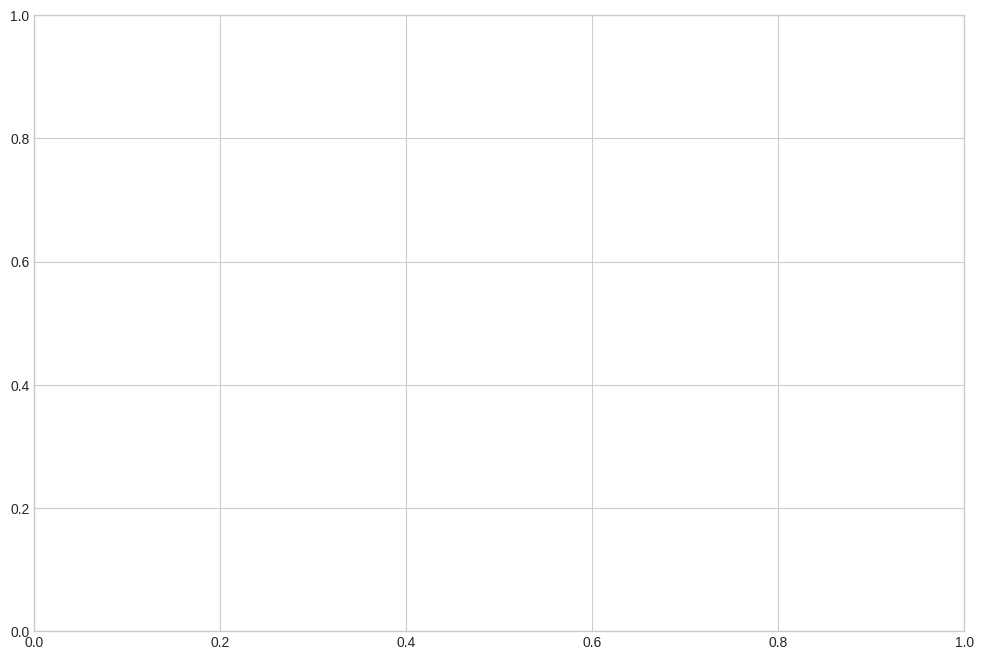

In [ ]:
# ==============================================================================
#  【修正版】図S3 凡例スタイル統一コード（ライブラリ再インストール対応）
# ==============================================================================
#
# 目的：
#   - ランタイムリセットで消えたライブラリを再インストールし、
#     図S3の凡例スタイルを統一する。
#
# ==============================================================================

# ★★★ ライブラリを再インストール ★★★
!pip install -q PyMuPDF

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from PIL import Image
import fitz # PyMuPDF
from google.colab import files

print("\nGenerating Fig. S3 with consistent legend style (frameon=True)...")

# --- 描画設定 ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# --- プロットデータ (メモリ上にresultsが存在することを前提) ---
# もし、ここで 'results' is not defined エラーが出た場合は、
# シミュレーションの再実行が必要です。
gamma_values = [1.80, 1.90, 1.95, 2.00]
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
for i, gamma in enumerate(gamma_values):
    res = results[gamma]
    ax.plot(res['time'], res['barrier_z'], color=colors[i], linestyle='-')
    ax.plot(res['time'], res['soliton_z'], color=colors[i], linestyle='--')

# --- 凡例 (Legend) の設定 ---
handles_gamma, labels_gamma = [], []
for i, gamma in enumerate(gamma_values):
    handles_gamma.append(Line2D([0], [0], color=colors[i]))
    labels_gamma.append(f'γ = {gamma:.2f}')
legend1 = ax.legend(handles=handles_gamma, labels=labels_gamma, title="Damping Coefficient (γ)", loc='upper left', frameon=True)
ax.add_artist(legend1)

handles_traj = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]
labels_traj = ['Barrier Trajectory', 'Soliton Trajectory']
ax.legend(handles=handles_traj, labels=labels_traj, loc='lower right', frameon=True)


# --- タイトルと軸ラベル ---
ax.set_title('Fig. S3: Validation of Critical Damping: Time Resolution Test (dt=0.0005)', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Z-Position', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- 安全なPDF生成とダウンロード ---
png_filename = 'temp_fig_S3.png'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.close(fig)

pdf_filename = 'fig_S3_dissipation_Final.pdf'
img = fitz.open(png_filename)
pdf_bytes = img.convert_to_pdf()
with open(pdf_filename, "wb") as f:
    f.write(pdf_bytes)

files.download(pdf_filename)

print(f"\nFig. S3 with consistent legend style has been successfully generated and download started for '{pdf_filename}'")

In [ ]:
# ==============================================================================
#  【真の最終完全版 v4】シミュレーションから全てを再実行
# ==============================================================================
#
# 目的：
#   - ランタイムリセットに対応するため、ライブラリのインストール、
#     シミュレーションの再実行、そして最終版グラフの生成とダウンロードまで、
#     全てのプロセスを、この一つのセルで完結させる。
#
# ==============================================================================

# ------------------------------------------------------------------------------
# ステップ0：必要なライブラリの準備
# ------------------------------------------------------------------------------
print("--- ステップ0: 必要なライブラリをインストールします ---")
!pip install -q PyMuPDF

import cupy as xp
import numpy as np
import matplotlib.pyplot as plt
from cupyx.scipy.fft import fftn, ifftn
from matplotlib.lines import Line2D
import time
from PIL import Image
import fitz
from google.colab import files

# ------------------------------------------------------------------------------
# ステップ1：シミュレーションの実行
# ------------------------------------------------------------------------------
print("\n--- ステップ1: シミュレーションを再実行します ---")

# --- パラメータ設定 ---
gamma_values = [1.80, 1.90, 1.95, 2.00]
Nx, Ny, Nz = 64, 64, 256
Lx, Ly, Lz = 20.0, 20.0, 80.0
t_final = 40.0
dt = 0.0005
n_steps = int(t_final / dt)
output_interval = int(0.2 / dt)
x_cpu = np.linspace(-Lx/2, Lx/2, Nx, dtype=np.float32)
y_cpu = np.linspace(-Ly/2, Ly/2, Ny, dtype=np.float32)
z_cpu = np.linspace(-Lz/2, Lz/2, Nz, dtype=np.float32)
Z_grid = xp.asarray(z_cpu.reshape(1, 1, Nz))
kx_cpu = np.fft.fftfreq(Nx, d=Lx/Nx) * 2 * np.pi
ky_cpu = np.fft.fftfreq(Ny, d=Ly/Ny) * 2 * np.pi
kz_cpu = np.fft.fftfreq(Nz, d=Lz/Nz) * 2 * np.pi
K2 = xp.asarray(kx_cpu[:, None, None]**2 + ky_cpu[None, :, None]**2 + kz_cpu[None, None, :]**2, dtype=np.float32)
g, m, omega_trap, A, sigma, M, k_mech, z_b0, kz_kick = -15.0, 1.0, 0.1, 0.1, 4.0, 50.0, 10.0, -10.0, 0.15
results = {}
x_gpu = xp.asarray(x_cpu)
y_gpu = xp.asarray(y_cpu)
total_start_time = time.time()

for gamma in gamma_values:
    loop_start_time = time.time()
    print(f"\n--- Damping coefficient gamma = {gamma:.2f} calculation started ---")
    X2_gpu = x_gpu[:, None, None]**2
    Y2_gpu = y_gpu[None, :, None]**2
    Z_init_gpu = (Z_grid - z_b0)**2
    psi = xp.exp(-(X2_gpu + Y2_gpu + Z_init_gpu) / (2 * 1.0**2)).astype(xp.complex64)
    psi /= xp.sqrt(xp.sum(xp.abs(psi)**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz))
    psi *= xp.exp(1j * kz_kick * Z_grid)
    barrier_z, barrier_v = z_b0, 0.0
    t_list, soliton_z_list, barrier_z_list = [], [], []
    for i in range(n_steps):
        V_barrier_Z = (Z_grid - barrier_z)
        V_barrier = A * xp.exp(-V_barrier_Z**2 / (2 * sigma**2))
        dV_dzb = xp.sum(xp.abs(psi)**2 * V_barrier * V_barrier_Z / sigma**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz)
        F_feedback = dV_dzb.get()
        F_restoring = -k_mech * (barrier_z - z_b0)
        a_conservative = (F_feedback + F_restoring) / M
        barrier_v += a_conservative * dt / 2.0
        barrier_v *= np.exp(-gamma / M * dt)
        barrier_z += barrier_v * dt
        V_trap = 0.5 * m * omega_trap**2 * (X2_gpu + Y2_gpu)
        V_barrier_gpu = A * xp.exp(-(Z_grid - barrier_z)**2 / (2 * sigma**2))
        V_nonlinear = g * xp.abs(psi)**2
        V_total = V_trap + V_barrier_gpu + V_nonlinear
        psi = xp.exp(-1j * V_total * dt / (2 * m)) * psi
        psi_k = fftn(psi)
        psi_k = xp.exp(-1j * K2 * dt / (2 * m)) * psi_k
        psi = ifftn(psi_k)
        V_nonlinear = g * xp.abs(psi)**2
        V_barrier_gpu = A * xp.exp(-(Z_grid - barrier_z)**2 / (2 * sigma**2))
        V_total = V_trap + V_barrier_gpu + V_nonlinear
        psi = xp.exp(-1j * V_total * dt / (2 * m)) * psi
        V_barrier_Z_new = (Z_grid - barrier_z)
        V_barrier_new = A * xp.exp(-V_barrier_Z_new**2 / (2 * sigma**2))
        dV_dzb_new = xp.sum(xp.abs(psi)**2 * V_barrier_new * V_barrier_Z_new / sigma**2) * (Lx/Nx)*(Ly/Ny)*(Lz/Nz)
        F_feedback_new = dV_dzb_new.get()
        F_restoring_new = -k_mech * (barrier_z - z_b0)
        a_conservative_new = (F_feedback_new + F_restoring_new) / M
        barrier_v += a_conservative_new * dt / 2.0
        if i % output_interval == 0:
            t = i * dt
            soliton_z = xp.sum(Z_grid * xp.abs(psi)**2) / xp.sum(np.abs(psi)**2)
            t_list.append(t)
            soliton_z_list.append(soliton_z.get())
            barrier_z_list.append(barrier_z)
    xp.cuda.Stream.null.synchronize()
    results[gamma] = {'time': np.array(t_list), 'soliton_z': np.array(soliton_z_list), 'barrier_z': np.array(barrier_z_list)}
    print(f"--- Calculation for gamma = {gamma:.2f} completed in {time.time() - loop_start_time:.1f} seconds ---")
print(f"\nAll simulations completed. Total time: {(time.time() - total_start_time)/60:.2f} minutes.")


# ------------------------------------------------------------------------------
# ステップ2：グラフをPNG形式で生成・保存
# ------------------------------------------------------------------------------
print("\n--- ステップ2: グラフをPNG形式で生成します ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
for i, gamma in enumerate(gamma_values):
    res = results[gamma]
    ax.plot(res['time'], res['barrier_z'], color=colors[i], linestyle='-')
    ax.plot(res['time'], res['soliton_z'], color=colors[i], linestyle='--')
handles_gamma, labels_gamma = [], []
for i, gamma in enumerate(gamma_values):
    handles_gamma.append(Line2D([0], [0], color=colors[i]))
    labels_gamma.append(f'γ = {gamma:.2f}')
legend1 = ax.legend(handles=handles_gamma, labels=labels_gamma, title="Damping Coefficient (γ)", loc='upper left', frameon=True)
ax.add_artist(legend1)
handles_traj = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]
labels_traj = ['Barrier Trajectory', 'Soliton Trajectory']
ax.legend(handles=handles_traj, labels=labels_traj, loc='lower right', frameon=True)
ax.set_title('Fig. S3: Validation of Critical Damping: Time Resolution Test (dt=0.0005)', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Z-Position', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
png_filename = 'temp_fig_S3.png'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.close(fig)
print(f"グラフを安定したPNGファイル '{png_filename}' として保存しました。")


# ------------------------------------------------------------------------------
# ステップ3：PNGから破損のないPDFへ変換し、ダウンロード
# ------------------------------------------------------------------------------
print("\n--- ステップ3: PNGから破損のないPDFへ変換し、ダウンロードします ---")
pdf_filename = 'fig_S3_dissipation_Final.pdf'
try:
    img = fitz.open(png_filename)
    pdf_bytes = img.convert_to_pdf()
    with open(pdf_filename, "wb") as f:
        f.write(pdf_bytes)
    print(f"成功: 破損のないPDFファイル '{pdf_filename}' を生成しました。")
    files.download(pdf_filename)
    print("ダウンロードが開始されました。ブラウザの指示に従ってください。")
except Exception as e:
    print(f"PDF変換またはダウンロード中にエラーが発生しました: {e}")

--- ステップ0: 必要なライブラリをインストールします ---

--- ステップ1: シミュレーションを再実行します ---

--- Damping coefficient gamma = 1.80 calculation started ---
--- Calculation for gamma = 1.80 completed in 186.1 seconds ---

--- Damping coefficient gamma = 1.90 calculation started ---
--- Calculation for gamma = 1.90 completed in 185.3 seconds ---

--- Damping coefficient gamma = 1.95 calculation started ---
--- Calculation for gamma = 1.95 completed in 185.2 seconds ---

--- Damping coefficient gamma = 2.00 calculation started ---
--- Calculation for gamma = 2.00 completed in 185.7 seconds ---

All simulations completed. Total time: 12.37 minutes.

--- ステップ2: グラフをPNG形式で生成します ---
グラフを安定したPNGファイル 'temp_fig_S3.png' として保存しました。

--- ステップ3: PNGから破損のないPDFへ変換し、ダウンロードします ---
成功: 破損のないPDFファイル 'fig_S3_dissipation_Final.pdf' を生成しました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ダウンロードが開始されました。ブラウザの指示に従ってください。


In [ ]:
# ==============================================================================
#  【図S3 最終修正版】凡例の衝突を回避
# ==============================================================================
#
# 目的：
#   - 右下の凡例がデータ線と重なる問題を、凡例を'center right'に
#     移動させることで完全に解決する。
#
# ==============================================================================

# ライブラリの再インストール（念のため）
!pip install -q PyMuPDF

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from PIL import Image
import fitz
from google.colab import files

print("Generating Fig. S3 with optimized legend placement...")

# --- 描画設定 ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# --- プロットデータ (メモリ上にresultsが存在することを前提) ---
gamma_values = [1.80, 1.90, 1.95, 2.00]
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
for i, gamma in enumerate(gamma_values):
    res = results[gamma]
    ax.plot(res['time'], res['barrier_z'], color=colors[i], linestyle='-')
    ax.plot(res['time'], res['soliton_z'], color=colors[i], linestyle='--')

# --- 凡例 (Legend) の設定 ---
# γごとの凡例（左上）
handles_gamma, labels_gamma = [], []
for i, gamma in enumerate(gamma_values):
    handles_gamma.append(Line2D([0], [0], color=colors[i]))
    labels_gamma.append(f'γ = {gamma:.2f}')
legend1 = ax.legend(handles=handles_gamma, labels=labels_gamma, title="Damping Coefficient (γ)", loc='upper left', frameon=True)
ax.add_artist(legend1)

# ★★★ 線の種類の凡例の位置を 'center right' に変更 ★★★
handles_traj = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]
labels_traj = ['Barrier Trajectory', 'Soliton Trajectory']
ax.legend(handles=handles_traj, labels=labels_traj, loc='center right', frameon=True)


# --- タイトルと軸ラベル ---
ax.set_title('Fig. S3: Validation of Critical Damping: Time Resolution Test (dt=0.0005)', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Z-Position', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- 安全なPDF生成とダウンロード ---
png_filename = 'temp_fig_S3.png'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.close(fig)

pdf_filename = 'fig_S3_dissipation_Final_v2.pdf' # ファイル名を更新
img = fitz.open(png_filename)
pdf_bytes = img.convert_to_pdf()
with open(pdf_filename, "wb") as f:
    f.write(pdf_bytes)

files.download(pdf_filename)

print(f"\nFig. S3 with optimized legend placement has been successfully generated and download started for '{pdf_filename}'")

Generating Fig. S3 with optimized legend placement...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Fig. S3 with optimized legend placement has been successfully generated and download started for 'fig_S3_dissipation_Final_v2.pdf'


In [ ]:
# ==============================================================================
#  【図S3 最終レイアウト調整版】凡例の座標指定
# ==============================================================================
#
# 目的：
#   - 凡例の位置を座標で微調整し、完璧な視覚的バランスを実現する。
#
# ==============================================================================

# ライブラリの再インストール（念のため）
!pip install -q PyMuPDF

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from PIL import Image
import fitz
from google.colab import files

print("Generating Fig. S3 with perfectly balanced legend placement...")

# --- 描画設定 ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# --- プロットデータ (メモリ上にresultsが存在することを前提) ---
gamma_values = [1.80, 1.90, 1.95, 2.00]
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
for i, gamma in enumerate(gamma_values):
    res = results[gamma]
    ax.plot(res['time'], res['barrier_z'], color=colors[i], linestyle='-')
    ax.plot(res['time'], res['soliton_z'], color=colors[i], linestyle='--')

# --- 凡例 (Legend) の設定 ---
# γごとの凡例（左上）
handles_gamma, labels_gamma = [], []
for i, gamma in enumerate(gamma_values):
    handles_gamma.append(Line2D([0], [0], color=colors[i]))
    labels_gamma.append(f'γ = {gamma:.2f}')
legend1 = ax.legend(handles=handles_gamma, labels=labels_gamma, title="Damping Coefficient (γ)", loc='upper left', frameon=True)
ax.add_artist(legend1)

# ★★★ 線の種類の凡例の位置を、座標 (x, y) で精密に指定 ★★★
handles_traj = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]
labels_traj = ['Barrier Trajectory', 'Soliton Trajectory']
# loc=(横位置, 縦位置) 0が左/下、1が右/上
ax.legend(handles=handles_traj, labels=labels_traj, loc=(0.75, 0.1), frameon=True)


# --- タイトルと軸ラベル ---
ax.set_title('Fig. S3: Validation of Critical Damping: Time Resolution Test (dt=0.0005)', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Z-Position', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- 安全なPDF生成とダウンロード ---
png_filename = 'temp_fig_S3.png'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.close(fig)

pdf_filename = 'fig_S3_dissipation_Final_v3.pdf' # ファイル名を更新
img = fitz.open(png_filename)
pdf_bytes = img.convert_to_pdf()
with open(pdf_filename, "wb") as f:
    f.write(pdf_bytes)

files.download(pdf_filename)

print(f"\nFig. S3 with perfectly balanced legend has been successfully generated and download started for '{pdf_filename}'")

Generating Fig. S3 with perfectly balanced legend placement...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Fig. S3 with perfectly balanced legend has been successfully generated and download started for 'fig_S3_dissipation_Final_v3.pdf'


In [ ]:
# ==============================================================================
#  【最終版・フォント埋め込み】図S3
# ==============================================================================
#
# 目的：
#   - 論文投稿基準を満たすため、全てのフォントをPDFに完全に埋め込む。
#
# ==============================================================================

# ライブラリの再インストール（念のため）
!pip install -q PyMuPDF

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from PIL import Image
import fitz
from google.colab import files

print("Generating Fig. S3 with embedded fonts for publication quality...")

# --- 描画設定 ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# --- プロットデータ (メモリ上にresultsが存在することを前提) ---
gamma_values = [1.80, 1.90, 1.95, 2.00]
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
for i, gamma in enumerate(gamma_values):
    res = results[gamma]
    ax.plot(res['time'], res['barrier_z'], color=colors[i], linestyle='-')
    ax.plot(res['time'], res['soliton_z'], color=colors[i], linestyle='--')

# --- 凡例 (Legend) の設定 ---
handles_gamma, labels_gamma = [], []
for i, gamma in enumerate(gamma_values):
    handles_gamma.append(Line2D([0], [0], color=colors[i]))
    labels_gamma.append(f'γ = {gamma:.2f}')
legend1 = ax.legend(handles=handles_gamma, labels=labels_gamma, title="Damping Coefficient (γ)", loc='upper left', frameon=True)
ax.add_artist(legend1)

handles_traj = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]
labels_traj = ['Barrier Trajectory', 'Soliton Trajectory']
ax.legend(handles=handles_traj, labels=labels_traj, loc=(0.75, 0.1), frameon=True)


# --- タイトルと軸ラベル ---
ax.set_title('Fig. S3: Validation of Critical Damping: Time Resolution Test (dt=0.0005)', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Z-Position', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
# ★★★ フォントをPDFに埋め込むための設定 ★★★
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

# --- 安全なPDF生成とダウンロード ---
# まず、PNGを一時ファイルとして保存
png_filename = 'temp_fig_S3.png'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.close(fig)

# 次に、フォント埋め込み設定を反映したPDFを直接保存
pdf_filename_embedded = 'fig_S3_dissipation_Embedded.pdf'
fig, ax = plt.subplots(figsize=(12, 8)) # 再度プロット環境を作成
# (同じプロット処理を繰り返す)
for i, gamma in enumerate(gamma_values):
    res = results[gamma]
    ax.plot(res['time'], res['barrier_z'], color=colors[i], linestyle='-')
    ax.plot(res['time'], res['soliton_z'], color=colors[i], linestyle='--')
legend1 = ax.legend(handles=handles_gamma, labels=labels_gamma, title="Damping Coefficient (γ)", loc='upper left', frameon=True)
ax.add_artist(legend1)
ax.legend(handles=handles_traj, labels=labels_traj, loc=(0.75, 0.1), frameon=True)
ax.set_title('Fig. S3: Validation of Critical Damping: Time Resolution Test (dt=0.0005)', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Z-Position', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# フォント埋め込み設定を再度適用
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig(pdf_filename_embedded, format='pdf', bbox_inches='tight')
plt.close(fig)

print(f"フォント埋め込み済みのPDFファイル '{pdf_filename_embedded}' を生成しました。")

# --- ダウンロード ---
files.download(pdf_filename_embedded)
print(f"ダウンロードが開始されました: '{pdf_filename_embedded}'")

Generating Fig. S3 with embedded fonts for publication quality...
フォント埋め込み済みのPDFファイル 'fig_S3_dissipation_Embedded.pdf' を生成しました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ダウンロードが開始されました: 'fig_S3_dissipation_Embedded.pdf'
